In [9]:
from SimPEG import * 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# DC Resistivity Simulations

DC resistivity is a zero-frequency electromagnetic problem. A DC resistivity geophysical survey is sensitive to variations in electrical conductivity. 

The governing equation is: 

$$
\nabla \cdot \sigma \nabla \phi = s
$$

where $\sigma$ is the electrical conductivity (S/m), $\phi$ is the electrical potential (V), and $s$ is the source.  

## Set up a Mesh

In [48]:
nx,ny = 50,50 # number of cells in x,y
mesh = Mesh.TensorMesh([nx,ny]) # build a tensor mesh
sigma = np.ones(mesh.nC) # assign a conductivity model

# create source
xp, yp = 0.25, 0.5
xn, yn = 0.75, 0.5
s = np.zeros(mesh.nC)
indp = Utils.closestPoints(mesh,np.r_[xp,yp],'CC')
indn = Utils.closestPoints(mesh,np.r_[xn,yn],'CC')
s[indp] = 1.
s[indn] = -1

In [55]:
# This can be hidden and imported depending on how much you want to expose
def getOperators(mesh,sigma):
    Div = mesh.faceDiv
    Sigma = Utils.sdiag(1/(mesh.aveF2CC.T * (1/sigma)))
    Grad = mesh.cellGrad
    return Div, Sigma, Grad

# DC Resistivity
## $ \nabla \cdot \sigma \nabla \phi = s $

In [51]:
# Construct A Matrix
Div, Sigma, Grad = getOperators(mesh,sigma)
A = Div * Sigma * Grad
Ainv = Solver(A)

In [52]:
phi = Ainv * s

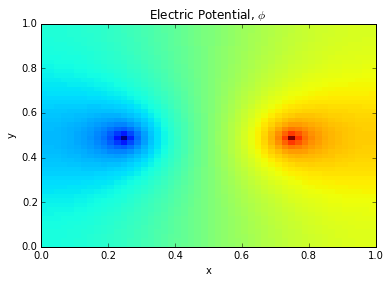

In [53]:
mesh.plotImage(phi)
plt.title('Electric Potential, $\phi$')

In [56]:
def MoveSrc(xp,yp,xn,yn):
    s = np.zeros(mesh.nC)
    indp = Utils.closestPoints(mesh,np.r_[xp,yp],'CC')
    indn = Utils.closestPoints(mesh,np.r_[xn,yn],'CC')
    s[indp] = 1.
    s[indn] = -1.
    
    phi = Ainv * s
    
    mesh.plotImage(phi)
    plt.title('Electric Potential, $\phi$')
    plt.show()

### SolverWarning ###: Accuracy on solve is above tolerance: 9.765625e-03 > 1.000000e-06


/Users/lindseyjh/git/python_symlinks/SimPEG/Utils/SolverUtils.py:13: RuntimeWarning: ### SolverWarning ###: Accuracy on solve is above tolerance: 9.765625e-03 > 1.000000e-06
  warnings.warn(msg, RuntimeWarning)


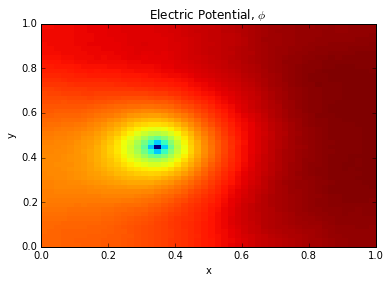

<function __main__.MoveSrc>

In [57]:
from IPython.html.widgets import *
interact(MoveSrc, xp=[0.25,0.5,0.05],yp=[0.25,0.75,0.05],xn=[0.5,0.75,0.05],yn=[0.25,0.75,0.05] )